In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import minimize_scalar
from scipy.optimize import curve_fit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

import re

# class

In [3]:
class dist_plot:
    '''
    Class for generating the plot, distance between species vs evolutionary time

    Methods:
    categorize : categorize genes based on their fdr value (stabilized selection for fdr < 0.05)
    residual : calculate orthogonal distance between species using pca
    power_fit : power fit to expression distance versus time (y=a*x^k)
    linear_fit : linear fit to expression distance versus time (y=m*x+n)
    calculate_mean : calculate mean squared distance from reference species. 
               First, mean across genes. Then, calculate mean & std across replicates in species
    plot : scatter plot with error bar & fitted lines
    run : run all the methods above, and get 3 plots, total genes, genes under stabilizing selection, 
          and genes under neutral evolution.
    '''

    def __init__(self,
                 X, 
                 dist_mat,
                 stat,
                 ref = "Human",
                 title = "distance plot"
                 ):
        '''
        Initialize class instance

        Arguments:
        X (dataframe) : RNA expression data, columns(samples) & rows(genes)
        dist_mat (dataframe) : evolutionary time difference from reference species
        stat (dataframe) : outcome of OU model containing gene_name, qvalues, thetas, var, and brownSigmas
        title (str) : title of plot
        '''
        
        self.X = X.copy()
        self.stat = stat
        self.ref = ref
        self.title = title

        # unique species in data
        col = [re.sub(r'\.\d+', '', col) for col in self.X.columns]
        self.species = np.unique(col)

        # extract the evolutionary time 
        self.timedata = dict(zip(dist_mat["species"],dist_mat[self.ref]))

        self.stabilized = []
        self.neutral = []
        self.res = self.residual()


    def categorize(self):
        for i, q in enumerate(self.stat["qvalues"]):
            if q < 0.05:
                self.stabilized.append(self.stat["gene_name"][i])      ## check the index of stat
            elif q > 0.05:
                self.neutral.append(self.stat["gene_name"][i])
        # stabilized selection
        self.stabilized = self.res[self.res.index.isin(self.stabilized)]
        # neutral evolution
        self.neutral = self.res[self.res.index.isin(self.neutral)]


    def residual(self):

        '''
        Calculate the mean squared distance using pca
        For given dataset, calculate the mean of reference species
        Then, perform pca for dataset composed of each sample and reference mean
        store the data projection to 2nd principal component
        '''

        # prepare reference mean
        ref_mean = [col for col in self.X.columns if self.ref in col]
        ref = self.X[ref_mean].mean(axis=1)

        ref_mean = np.log10(ref + 0.01) 
        data = np.log10(self.X + 0.01)
        data = data[(~data.isna().any(axis=1)) & (~ref_mean.isna())]

        # perform pca
        print("performing pca")
        residuals = {}
        for col in data.columns:
            other = data[col]
            other_data = other
            ref_data = ref_mean[other.index]
            #ref_data = ref_mean[(ref_mean > 0) & (other > 0)]
            #other_data = other[(ref_mean > 0) & (other > 0)]
            t = np.stack([ref_data, other_data], axis=1)
            m = PCA(n_components=2).fit(t)
            res = m.transform(t)[:, 1]
            if m.components_[1, 1] < 0:
                res *= -1
            residuals[col] = res

        residuals = pd.DataFrame(residuals, columns=data.columns, index=data.index)

        return residuals


    def f(self, t, a, k):
        # power law fitting
        return a*t**k

    def power_fit(self, mean, t):
        try:
            # curve fit
            popt, pcov = curve_fit(self.f, xdata=t, ydata=mean, p0=(1,1),maxfev=1000)
            a = popt[0]
            k = popt[1]

            # r2
            residuals = mean-self.f(t,*popt)
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((mean-np.mean(mean))**2)
            r2 = 1-(ss_res/ss_tot)

        except RuntimeError:
            a = None
            k = None
            r2 = None
            
        return r2, a, k


    def linear_fit(self, y, x):
        # linear regression model & fit
        model = sm.OLS(y, x)
        result = model.fit()

        # coefficients
        coefficients = result.params
        r2 = result.rsquared
        m=coefficients[1]
        n=coefficients[0]

        return r2, m, n
    

    def calculate_mean(self, data):
        data = data.apply(lambda col: col.fillna(col.mean()), axis=0)
        col = data.columns

        # ref mean
        idx = [j for j in col if self.ref in j]    # index for reference species
        ref = data[idx].mean(axis=1)

        # mean & std across species
        mean = pd.DataFrame()
        mean_dist = {}
        std_dist = {}
        for i in self.species:
            idx = [j for j in col if i in j]
            for j in idx:
                mean[j] = (data[j]-ref)**2

            mean_dist[i] = np.mean(mean[idx].mean(axis=1, skipna=True))
            if len(idx) > 1:
                std_dist[i] = np.mean(mean[idx].std(axis=1, skipna=True))
            else:
                std_dist[i] = 0

        # sort mean, std, and time to get same order
        df = {}
        for s in self.species:
            df[s] = [self.timedata[s], mean_dist[s], std_dist[s]]

        df = pd.DataFrame(df)
        return df


    def plot(self, data):
        df = self.calculate_mean(data)

        #plt.errorbar(df.iloc[0,:], df.iloc[1,:], yerr=df.iloc[2,:], fmt='o', ecolor='b', capsize=1)
        plt.scatter(df.iloc[0,:], df.iloc[1,:])

        x = np.linspace(0, max(df.iloc[0,:])+0.1, 100)

        # linear fit
        r2_l, m, n = self.linear_fit(np.array(df.iloc[1,:]), sm.add_constant(np.array(df.iloc[0,:])))
        plt.plot(x, m*x+n, label=f'linear, r2={r2_l:.2f}')

        # power fit
        r2_p, a, k = self.power_fit(df.iloc[1,:], df.iloc[0,:])
        plt.plot(x, a*x**(k), label = f"power, r2={r2_p:.2f}")

        for i in self.species:
            plt.annotate(i[:4], (df.loc[0, i], df.loc[1,i]), fontsize='small')

        plt.xlabel("evolutionary time")
        plt.ylabel("Mean Squared Expression Distance")
        plt.legend()
        plt.title(f"gene : {data.shape[0]}, {self.title}")
        plt.show()


    def run(self):
        # total genes
        self.plot(data = self.res)

        self.categorize()
        # stabilizing selection
        self.title = "Stabilized Selection"
        self.plot(data = self.stabilized)

        # neutral evolution
        self.title = "Neutral Evolution"
        self.plot(data = self.neutral)

    
    def compare(self):
        gene = self.X.index
        
        result = {"R2_l":np.zeros(len(gene)),"R2_p":np.zeros(len(gene)),
                  "m":np.zeros(len(gene)), "n":np.zeros(len(gene)),
                  "a":np.zeros(len(gene)), "k":np.zeros(len(gene))}

        # ref mean
        idx = [j for j in self.X.columns if self.ref in j]    # index for reference species
        ref = self.X[idx].mean(axis=1)

        # mean & std across species
        mean = pd.DataFrame()
        mean_dist = {}
        for i in self.species:
            idx = [j for j in self.X.columns if i in j]
            for j in idx:
                mean[j] = (self.X[j]-ref)**2
            mean_dist[i] = mean[idx].mean(axis=1, skipna=True)

        for i,g in enumerate(gene):
            if i % 1000 == 0:
                print(i)
            df = pd.DataFrame({
            s: [self.timedata[s], mean_dist[s][i]] for s in self.species
            })
            
            try:
                # linear fit
                result["R2_l"][i], result["m"][i], result["n"][i] = self.linear_fit(np.array(df.iloc[1,:]), sm.add_constant(np.array(df.iloc[0,:])))
                # power fit
                result["R2_p"][i], result["a"][i], result["k"][i] = self.power_fit(df.iloc[1,:], df.iloc[0,:])
            except ValueError:
                result["R2_l"][i], result["m"][i], result["n"][i] = [None, None, None]
                result["R2_p"][i], result["a"][i], result["k"][i] = [None, None, None]

        result = pd.DataFrame(result)
        result.insert(0,"gene_name",gene)

        ## compare with fdr values
        pfit = result[result["R2_l"]<result["R2_p"]]["gene_name"]
        fdr = np.zeros(len(pfit))
        for i, s in enumerate(pfit):
            fdr[i] = self.stat[self.stat["gene_name"]==s]["qvalues"].values

        plt.hist(fdr, color = 'blue', edgecolor = 'black', bins=int(300))
        plt.xlabel("fdr")
        plt.ylabel("number of genes with better fit to power law")
        plt.xlim(0, 1)
        plt.show()

        return result

# input data

In [4]:
# check the columns 
raw = pd.read_csv("/Users/yunseong-eun/Desktop/processed_chen/subset/exp_data/liver.txt", delimiter="\t")
raw = raw.drop("#ensembl", axis=1)
raw = raw.set_index("gene_name")
raw

,human,human.1,chimp,bonobo,gorilla,rhesus,rhesus.1,rhesus.2,rhesus.3,rhesus.4,...,rat.1,rat.2,rabbit,dog,ferret,cow,cow.1,cow.2,opossum,opossum.1
gene_name,,,,,,,,,,,,,,,,,,,,,
NFYA,3.78,2.50,5.80,5.07,8.10,9.00,8.98,8.63,6.11,8.57,...,3.47,4.77,6.92,3.85,19.22,7.31,6.68,10.29,2.82,5.31
IBTK,11.09,10.15,8.87,12.01,12.63,7.07,21.99,26.18,24.91,38.90,...,28.53,27.65,32.48,5.70,22.99,12.31,9.47,5.27,9.63,10.00
IFI35,17.41,16.29,26.28,13.27,22.41,16.04,12.99,14.83,6.40,20.80,...,27.50,31.94,40.86,30.32,26.49,19.06,31.64,24.96,24.53,34.20
TAL1,0.48,0.37,2.48,0.62,1.08,NaN,NaN,NaN,NaN,NaN,...,0.81,0.72,0.72,0.11,0.92,1.04,2.19,2.39,1.70,1.74
ELAVL4,0.04,0.06,0.03,0.15,0.07,0.63,0.00,0.02,0.00,0.10,...,0.00,0.00,0.40,0.00,0.03,0.00,0.00,0.00,0.00,0.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZFPL1,20.40,12.44,31.96,11.92,16.30,37.75,18.95,12.75,15.22,14.99,...,7.17,10.78,12.77,8.35,13.17,9.68,14.19,22.11,32.01,23.45
RPS6KA4,15.83,3.71,9.07,4.24,NaN,15.84,12.50,6.86,5.25,7.05,...,8.37,8.02,NaN,8.10,12.29,4.95,4.64,11.72,15.66,11.63
LRP5,156.04,58.18,102.01,26.23,21.25,131.67,114.33,64.92,61.33,52.23,...,52.40,61.09,5.02,59.50,74.62,31.76,39.71,126.05,38.50,35.37


In [5]:
# distance matrix 
dist_mat = pd.read_csv("/Users/yunseong-eun/Desktop/processed_chen/Chen_DistMat.csv")
dist_mat

,species,opossum,armadillo,cow,dog,ferret,rabbit,rat,musCaroli,musSpretus,musMusculus,marmoset,rhesus,orangutan,gorilla,chimp,bonobo,human
0,opossum,0.0000,0.7613,0.8874,0.8224,0.8454,0.8652,1.0161,1.0103,1.0103,1.0103,0.7934,0.7838,0.7790,0.7787,0.7784,0.7784,0.7784
1,armadillo,0.7613,0.0000,0.4617,0.3967,0.4197,0.4395,0.5904,0.5846,0.5846,0.5846,0.3677,0.3581,0.3533,0.3530,0.3527,0.3527,0.3527
2,cow,0.8874,0.4617,0.0000,0.4070,0.4300,0.5206,0.6715,0.6657,0.6657,0.6657,0.4488,0.4392,0.4344,0.4341,0.4338,0.4338,0.4338
3,dog,0.8224,0.3967,0.4070,0.0000,0.2018,0.4556,0.6065,0.6007,0.6007,0.6007,0.3838,0.3742,0.3694,0.3691,0.3688,0.3688,0.3688
4,ferret,0.8454,0.4197,0.4300,0.2018,0.0000,0.4786,0.6295,0.6237,0.6237,0.6237,0.4068,0.3972,0.3924,0.3921,0.3918,0.3918,0.3918
5,rabbit,0.8652,0.4395,0.5206,0.4556,0.4786,0.0000,0.5809,0.5751,0.5751,0.5751,0.3842,0.3746,0.3698,0.3695,0.3692,0.3692,0.3692
6,rat,1.0161,0.5904,0.6715,0.6065,0.6295,0.5809,0.0000,0.1772,0.1772,0.1772,0.5351,0.5255,0.5207,0.5204,0.5201,0.5201,0.5201
7,musCaroli,1.0103,0.5846,0.6657,0.6007,0.6237,0.5751,0.1772,0.0000,0.0580,0.0580,0.5293,0.5197,0.5149,0.5146,0.5143,0.5143,0.5143
8,musSpretus,1.0103,0.5846,0.6657,0.6007,0.6237,0.5751,0.1772,0.0580,0.0000,0.0250,0.5293,0.5197,0.5149,0.5146,0.5143,0.5143,0.5143
9,musMusculus,1.0103,0.5846,0.6657,0.6007,0.6237,0.5751,0.1772,0.0580,0.0250,0.0000,0.5293,0.5197,0.5149,0.5146,0.5143,0.5143,0.5143


In [6]:
# result of model, including gene_name, qvalues, theta, ou variance, and brown sigmas
stat = pd.read_csv("/Users/yunseong-eun/Desktop/processed_chen/subset/subset_OU/liver.txt",delimiter="\t")
stat

,Unnamed: 0,gene_name,qvalues,thetas,var,alphas,sigmas,logLik,brownSigmas
0,0,NFYA,1.811676e-06,0.750416,0.029203,1893.608838,110.596841,3.809598,2.530226
1,1,IBTK,2.995344e-02,1.190873,0.056991,13.772426,1.569808,1.738785,0.505616
2,2,IFI35,2.842793e-05,1.388878,0.022120,2928.252017,129.543072,5.357046,0.998536
3,3,TAL1,1.158284e-06,-0.136746,0.122821,1814.081318,445.614027,-4.039508,11.878824
4,4,ELAVL4,5.445580e-03,-1.507764,0.329612,19.289486,12.716085,-8.228334,4.193731
...,...,...,...,...,...,...,...,...,...
10893,10893,ZFPL1,7.436056e-07,1.167777,0.028952,1464.872659,84.820770,3.897919,3.182913
10894,10894,RPS6KA4,1.447188e-06,0.860749,0.025435,1434.085716,72.950897,4.153256,3.052140
10895,10895,LRP5,4.005784e-04,1.628711,0.116700,128.495690,29.990870,-3.625792,2.985312
10896,10896,FGF19,4.477792e-06,-1.786341,0.125886,2073.998789,522.173891,-4.231465,8.681156


# test

performing pca


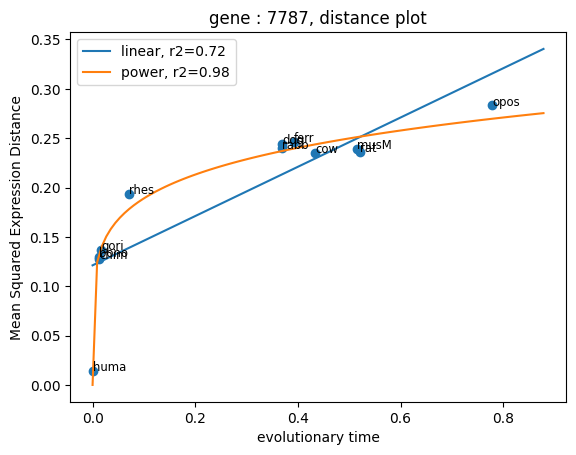

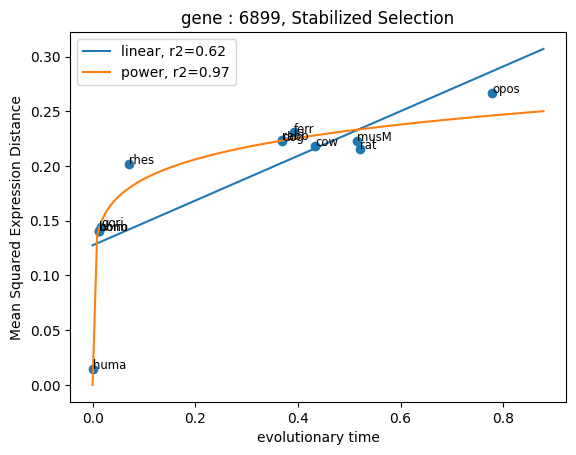

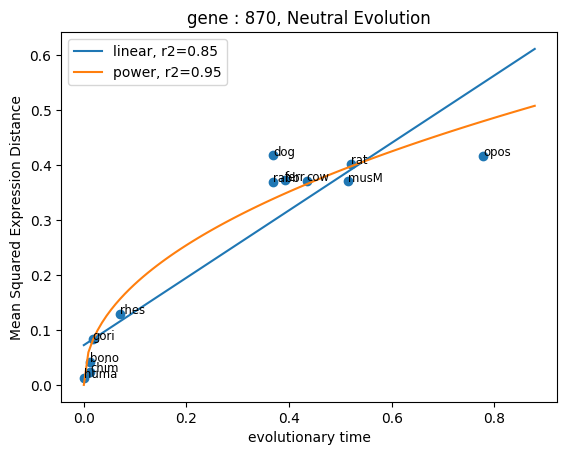

In [7]:
a = dist_plot(raw, dist_mat, stat, ref = "human")
a.run()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


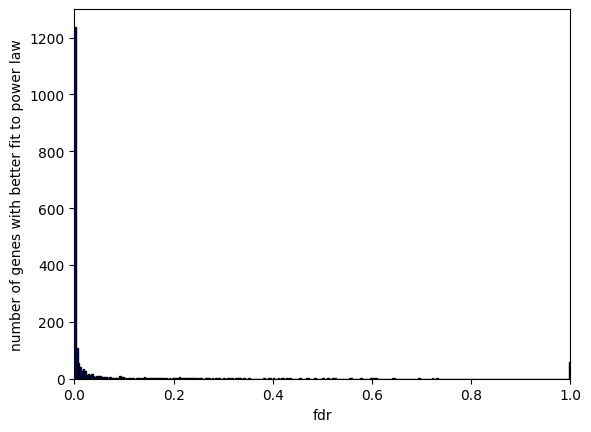

,gene_name,R2_l,R2_p,m,n,a,k
0,NFYA,0.010297,-0.181102,28.095040,24.012784,2.804738,6.818695e-08
1,IBTK,0.024721,-0.467309,97.567227,80.167015,2.794244,9.080267e-07
2,IFI35,0.252539,-0.870812,305.164045,55.719570,3.202410,6.738614e-07
3,TAL1,NaN,NaN,NaN,NaN,NaN,NaN
4,ELAVL4,0.003015,0.024400,-0.008059,0.020204,0.021654,5.720420e-02
...,...,...,...,...,...,...,...
10893,ZFPL1,0.000005,0.028588,0.589770,58.845514,66.757007,3.799786e-10
10894,RPS6KA4,NaN,NaN,NaN,NaN,NaN,NaN
10895,LRP5,0.020799,-2.047762,1661.817901,3629.608507,2.548137,2.261025e-06
10896,FGF19,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
result = a.compare()
result